In [38]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [40]:
def GetSensor(use_i,sensor_i):
    sql_s = "SELECT timestamp_ms, value FROM data WHERE data_capture_id={} AND sensor_id={}".format(use_i,sensor_i)
    conn = sqlite3.connect('data/toilet.db')
    cursor = conn.execute(sql_s)
    time_measurements = []
    distance_measurements = []
    for row in cursor:
        time_measurements.append(row[0])
        distance_measurements.append(row[1])
    #endfor
    data_t = (time_measurements,distance_measurements)
    return data_t
#enddef

def cleanSensors(sensor1_t_l,sensor1_y_l,sensor2_t_l,sensor2_y_l):

    # get min / max of time-series
    #sensor1_t_l = data_d[1][0]
    #sensor2_t_l = data_d[2][0]
    #sensor1_y_l = data_d[1][1]
    #sensor2_y_l = data_d[2][1]
    min_t = min(min(sensor1_t_l),min(sensor2_t_l))
    max_t = max(max(sensor1_t_l),max(sensor2_t_l))

    # setup partitions
    step_t = 500
    min_floor_t = int(np.floor(min_t/step_t)*step_t)
    max_ceil_t = int(np.ceil(max_t/step_t)*step_t)
    
    step1_d = {}
    step2_d = {}
    for i in range(min_floor_t,max_ceil_t+step_t,step_t):
        step1_d[i] = []
        step2_d[i] = []
    #endfor

    # step through both and assign values to each partition
    for i in range(len(sensor1_t_l)):
        interval_t = int(np.floor(sensor1_t_l[i]/step_t)*step_t)
        step1_d[interval_t].append(sensor1_y_l[i])
    #endfor
    for i in range(len(sensor2_t_l)):
        interval_t = int(np.floor(sensor2_t_l[i]/step_t)*step_t)
        step2_d[interval_t].append(sensor2_y_l[i])
    #endfor

    # step through each partition and either take averages or set to nan
    clean1_d = {}
    for i in step1_d.keys():
        if(len(step1_d[i]) > 0):
            clean1_d[i] = np.mean(step1_d[i])
    #endfor
    clean1_sz = pd.Series(clean1_d)

    clean2_d = {}
    for i in step2_d.keys():
        if(len(step2_d[i]) > 0):
            clean2_d[i] = np.mean(step2_d[i])
    #endfor
    clean2_sz = pd.Series(clean2_d)
    
    return clean1_sz, clean2_sz

def GetTotalWeight(data_capture_id):
    data_d = {}
    data_d[2] = GetSensor(data_capture_id, 2) # seat scale
    data_d[3] = GetSensor(data_capture_id, 3) # foot scale
    
    #t0 = data_d[2][0][0]
    
    clean1_sz, clean2_sz = cleanSensors(data_d[2][0],data_d[2][1],data_d[3][0],data_d[3][1])
    seatScale_sz = clean1_sz/1000
    footScale_sz = clean2_sz/1000
    sumScale_sz = seatScale_sz  + footScale_sz
    #sumScaleFiltered_sz = pd.Series(signal.medfilt(sumScale_sz, 11))
        
    sumScale_sz.index = (sumScale_sz.index - sumScale_sz.index[0])/1000
    #x_ix = sumScale_sz.index
    return sumScale_sz

In [10]:
data_capture_id = 1767
sample_rate = 44100

directory_name = "data/data_frames/data_capture_" + str(data_capture_id)
wav_fn = directory_name + "/audio_data.wav"
x, fs = librosa.load(wav_fn, sr = sample_rate, mono = False)

In [36]:
def GetAudio(use_i):
    sampleRate_n = 44100
    wav_fn  = 'data/data_frames/data_capture_{}/back_audio_data.wav'.format(use_i)
    if use_i > 1760:
        wav_fn  = 'data/data_frames/data_capture_{}/audio_data.wav'.format(use_i)
    x, fs = librosa.load(wav_fn,sr=sampleRate_n)

    # remove beeming
    #cutoff = 2048; fs = 44100
    #x = butter_lowpass_filter(x, cutoff, fs)

    n_fft = 2048; hop_length = 512; n_mels = 128
    S = librosa.feature.melspectrogram(x, sr=sampleRate_n, n_fft=n_fft, 
                                       hop_length=hop_length, 
                                       n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)

    return S_DB, fs, hop_length

In [54]:
def frame(data, window_length, hop_length):
    num_samples = data.shape[0]
    num_frames = 1 + int(np.floor((num_samples - window_length) / hop_length))
    shape = (num_frames, window_length) + data.shape[1:]
    strides = (data.strides[0] * hop_length,) + data.strides
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)


def get_audio_energy_ratio_sz(self, capture_id):
    sample_rate = 44100
    WINDOW_SECONDS = 1  
    HOP_SECONDS = 1 
    window_length = int(round(WINDOW_SECONDS * sample_rate))
    hop_length = int(round(HOP_SECONDS * sample_rate))

    directory_name = "data/data_frames/data_capture_" + str(capture_id)
    back_wav_fn = directory_name + "/back_audio_data.wav"
    x_back, fs = librosa.load(back_wav_fn,sr=sample_rate)
    front_wav_fn = directory_name + "/front_audio_data.wav"
    x_front, fs = librosa.load(front_wav_fn,sr=sample_rate)

    back_frames = frame(x_back,window_length,hop_length)
    front_frames = frame(x_front,window_length,hop_length)

    energy_back = np.sum(back_frames*back_frames, 1)
    energy_front = np.sum(front_frames*front_frames, 1)
    energy_ratio_front_to_back = np.divide(energy_front, energy_back)

    index = np.array(range(energy_ratio_front_to_back.shape[0])) * WINDOW_SECONDS

    audio_energy_ratio_sz = pd.Series(energy_ratio_front_to_back, index)
    return audio_energy_ratio_sz

def get_audio_energy_ratio_sz(data_capture_id):
    sample_rate = 44100
    WINDOW_SECONDS = 1; HOP_SECONDS = 1 
    window_length = int(round(WINDOW_SECONDS * sample_rate))
    hop_length = int(round(HOP_SECONDS * sample_rate))
    
    directory_name = "data/data_frames/data_capture_" + str(data_capture_id)
    wav_fn = directory_name + "/audio_data.wav"
    x, fs = librosa.load(wav_fn,sr = sample_rate, mono = False)
    
    x_1, x_2 = x[0], x[1]
    frames_1 = frame(x_1, window_length,hop_length)
    frames_2 = frame(x_2, window_length,hop_length)

    energy_1 = np.sum(frames_1 * frames_1, 1)
    energy_2 = np.sum(frames_2 * frames_2, 1)
    energy_ratio = np.divide(energy_1, energy_2)

    index = np.array(range(energy_ratio.shape[0])) * WINDOW_SECONDS

    audio_energy_ratio_sz = pd.Series(energy_ratio, index)
    return audio_energy_ratio_sz

In [55]:
def plotEnergyRatioSpectrogram(data_capture_id):
    fig, axes = plt.subplots(3, 1, figsize = (10, 9), sharex = True)
    
    total_weight_sz = GetTotalWeight(data_capture_id)
    axes[0].plot(total_weight_sz)
    axes[0].set_ylim(total_weight_sz.median()-0.3, total_weight_sz.median()+0.3)
    axes[0].title.set_text("{}".format(data_capture_id))
    
    sz = get_audio_energy_ratio_sz(data_capture_id)
    axes[1].plot(sz)
    
    S_DB, fs, hop_len = GetAudio(data_capture_id)
    axes[2] = librosa.display.specshow(S_DB, sr=fs, hop_length=hop_len, x_axis='time', y_axis='mel')
    plt.show()

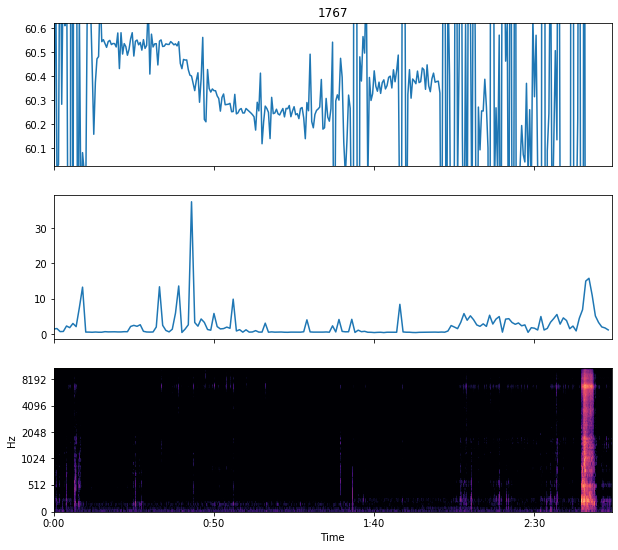

In [56]:
plotEnergyRatioSpectrogram(1767)

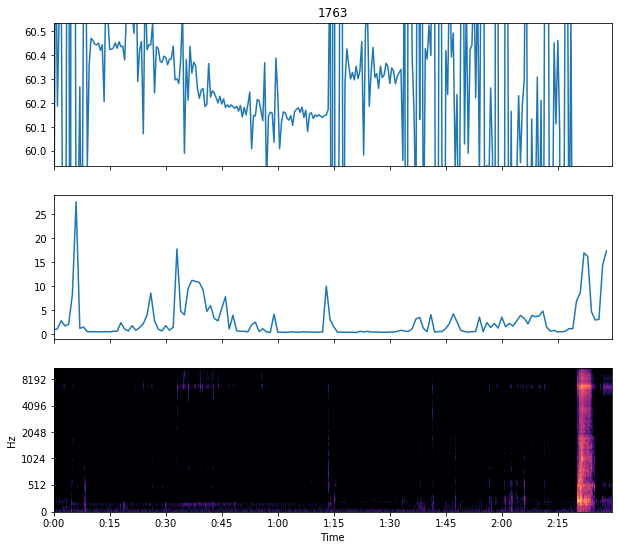

In [57]:
plotEnergyRatioSpectrogram(1763)

In [ ]:
plotEnergyRatioSpectrogram(1763)